# Instructions for Damien and Ros

### please run all cells marked with a * before them, and all cells for parts I have allotted you
I will be running the text + image modality one

- Ros: please run text modality
- Damien: please run image modality

# *Imports

In [2]:
import os
import sys
import itertools
from collections import defaultdict

from sklearn.decomposition import TruncatedSVD, PCA

import scipy.sparse as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from adjustText import adjust_text

from tqdm import tqdm
from PIL import Image
import requests
from io import BytesIO

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

import torch

import cornac
from cornac.utils import cache
from cornac.data import Dataset
from cornac.eval_methods import RatioSplit
from cornac.models import MF, WMF, EASE, VBPR
from cornac.models.dmrl import DMRL
from cornac.data import TextModality, ImageModality

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = False

c:\Users\user\.conda\envs\cs608_p2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


System version: 3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Cornac version: 2.2.1
Tensorflow version: 2.16.1


# *Load dataset

In [3]:
ratings_path = '../data/01_raw/rating.csv'
anime_path = '../data/03_primary/anime_final_cleaned.csv'

In [4]:
ratings = pd.read_csv(ratings_path)
content = pd.read_csv(anime_path)

In [5]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [6]:
content.head()

,anime_id,name,type,episodes,mal_score,members,studio,release-season,release-year,release-date,...,themes,demographics,synopsis,image_url,rating,va_list,staff_list,recommended_review_count,mixedfeelings_review_count,notrecommended_review_count
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,['CoMix Wave Films'],summer,2016.0,NaN,...,[],NaN,"Mitsuha Miyamizu, a high school girl, yearns t...",https://cdn.myanimelist.net/images/anime/5/870...,PG-13 - Teens 13 or older,"['Kamishiraishi, Mone', 'Kamiki, Ryunosuke', '...","['Bezerra, Wendel', 'Kawamura, Genki', 'Itou, ...",808.0,88.0,50.0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,['Bones'],spring,2009.0,NaN,...,['Military'],Shounen,After a horrific alchemy experiment goes wrong...,https://cdn.myanimelist.net/images/anime/1208/...,R - 17+ (violence & profanity),"['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","['Cook, Justin', 'Maruyama, Hiroo', 'Yonai, No...",912.0,59.0,39.0
2,28977,Gintama°,TV,51,9.25,114262,['Bandai Namco Pictures'],spring,2015.0,NaN,...,"['Gag Humor', 'Historical', 'Parody', 'Samurai']",Shounen,"Gintoki, Shinpachi, and Kagura return as the f...",https://cdn.myanimelist.net/images/anime/3/720...,PG-13 - Teens 13 or older,"['Sugita, Tomokazu', 'Kugimiya, Rie', 'Sakaguc...","['Miyawaki, Chizuru', 'Takamatsu, Shinji', 'Yo...",79.0,3.0,1.0
3,9253,Steins;Gate,TV,24,9.17,673572,['White Fox'],spring,2011.0,NaN,...,[],NaN,Eccentric scientist Rintarou Okabe has a never...,https://cdn.myanimelist.net/images/anime/1935/...,PG-13 - Teens 13 or older,"['Miyano, Mamoru', 'Imai, Asami', 'Hanazawa, K...","['Cook, Justin', 'Iwasa, Gaku', 'Kananiwa, Koz...",1007.0,73.0,73.0
4,9969,Gintama&#039;,TV,51,9.16,151266,['Sunrise'],spring,2011.0,NaN,...,"['Gag Humor', 'Historical', 'Parody', 'Samurai']",Shounen,"After a one-year hiatus, Shinpachi Shimura ret...",https://cdn.myanimelist.net/images/anime/4/503...,PG-13 - Teens 13 or older,"['Sugita, Tomokazu', 'Kugimiya, Rie', 'Sakaguc...","['Fujita, Youichi', 'Kobayashi, Katsuyoshi', '...",39.0,1.0,1.0


# *Preprocessing

In [7]:
# clean user_id
all_users = ratings['user_id'].unique()
print(f"number of users = {len(all_users)}")

number of users = 73515


In [8]:
print(f"user_id ranges from: {ratings['user_id'].min()} to {ratings['user_id'].max()}")

user_id ranges from: 1 to 73516


There is a single missing user_id within the range. To remap the user_ids.

In [9]:
max = ratings['user_id'].max()
# use property of arithmetic series :) (thanks leetcode! O(1))
missing = (max * (max+1)) / 2 - all_users.sum()
missing

46809.0

In [10]:
# double check whether that really is the missing user_id
id_46809_in_users = 46809 in all_users
id_46809_in_users

False

In [11]:
# double check whether all other values are present in the column. O(n)
all_users_set = set(all_users)
all_others_present = True
for user in range(1, ratings['user_id'].max() + 1):
    if user == 46809:
        continue
    else:
        if user in all_users_set:
            continue
        all_others_present = False
        break
    
all_others_present

True

In [12]:
# instead of remapping the entire user_id column, we can just change last user 73516 to 46809.
ratings[ratings["user_id"]==73516]

,user_id,anime_id,rating
7813735,73516,790,9
7813736,73516,8074,9


In [13]:
ratings["user_id"] = ratings["user_id"].replace(73516, 46809)
ratings[ratings["user_id"]==46809]

,user_id,anime_id,rating
7813735,46809,790,9
7813736,46809,8074,9


In [14]:
# discard ratings for items not in final anime list
filtered_ratings = pd.merge(
    content, 
    ratings, 
    on="anime_id", 
    how="left", 
    suffixes=["_left", ""]
)[["user_id", "anime_id", "rating"]].sort_values(by=['user_id'])

filtered_ratings

,user_id,anime_id,rating
4233377,1,18753,-1
6457401,1,25099,-1
268512,1,2001,-1
7055089,1,21033,-1
6293141,1,9041,-1
...,...,...,...
2628104,73515,317,9
5431394,73515,12293,8
6467256,73515,2404,9
4316751,73515,2596,7


In [15]:
# find out how many ratings were lost due to missing synopsis and/or cover image
print(f"lost ratings due to missing synopsis and/or cover image {len(ratings) - len(filtered_ratings)}")

lost ratings due to missing synopsis and/or cover image 6063


In [16]:
# reindex items
anime_remap = {}
sorted_content = content.sort_values(by=['anime_id'])
all_anime = sorted_content['anime_id'].unique()

counter = 1
for anime in all_anime:
    anime_remap[anime] = counter
    counter += 1

content["anime_id_remapped"] = content["anime_id"].map(anime_remap)
content.head()

,anime_id,name,type,episodes,mal_score,members,studio,release-season,release-year,release-date,...,demographics,synopsis,image_url,rating,va_list,staff_list,recommended_review_count,mixedfeelings_review_count,notrecommended_review_count,anime_id_remapped
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,['CoMix Wave Films'],summer,2016.0,NaN,...,NaN,"Mitsuha Miyamizu, a high school girl, yearns t...",https://cdn.myanimelist.net/images/anime/5/870...,PG-13 - Teens 13 or older,"['Kamishiraishi, Mone', 'Kamiki, Ryunosuke', '...","['Bezerra, Wendel', 'Kawamura, Genki', 'Itou, ...",808.0,88.0,50.0,10683
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,['Bones'],spring,2009.0,NaN,...,Shounen,After a horrific alchemy experiment goes wrong...,https://cdn.myanimelist.net/images/anime/1208/...,R - 17+ (violence & profanity),"['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","['Cook, Justin', 'Maruyama, Hiroo', 'Yonai, No...",912.0,59.0,39.0,3953
2,28977,Gintama°,TV,51,9.25,114262,['Bandai Namco Pictures'],spring,2015.0,NaN,...,Shounen,"Gintoki, Shinpachi, and Kagura return as the f...",https://cdn.myanimelist.net/images/anime/3/720...,PG-13 - Teens 13 or older,"['Sugita, Tomokazu', 'Kugimiya, Rie', 'Sakaguc...","['Miyawaki, Chizuru', 'Takamatsu, Shinji', 'Yo...",79.0,3.0,1.0,9753
3,9253,Steins;Gate,TV,24,9.17,673572,['White Fox'],spring,2011.0,NaN,...,NaN,Eccentric scientist Rintarou Okabe has a never...,https://cdn.myanimelist.net/images/anime/1935/...,PG-13 - Teens 13 or older,"['Miyano, Mamoru', 'Imai, Asami', 'Hanazawa, K...","['Cook, Justin', 'Iwasa, Gaku', 'Kananiwa, Koz...",1007.0,73.0,73.0,5648
4,9969,Gintama&#039;,TV,51,9.16,151266,['Sunrise'],spring,2011.0,NaN,...,Shounen,"After a one-year hiatus, Shinpachi Shimura ret...",https://cdn.myanimelist.net/images/anime/4/503...,PG-13 - Teens 13 or older,"['Sugita, Tomokazu', 'Kugimiya, Rie', 'Sakaguc...","['Fujita, Youichi', 'Kobayashi, Katsuyoshi', '...",39.0,1.0,1.0,5969


In [17]:
filtered_ratings["anime_id_remapped"] = filtered_ratings["anime_id"].map(anime_remap)
filtered_ratings.head()

,user_id,anime_id,rating,anime_id_remapped
4233377,1,18753,-1,7893
6457401,1,25099,-1,9175
268512,1,2001,-1,1817
7055089,1,21033,-1,8314
6293141,1,9041,-1,5585


In [18]:
# map came from content dataframe, double check if filtered_ratings was remapped properly
filtered_ratings["anime_id_remapped"].isna().sum()

0

In [19]:
# take only the columns we want
ratings_cleaned = filtered_ratings[["user_id", "anime_id_remapped", "rating"]]

# *Explore different encodings
Encoding "Watched but not rated" as -1 may cause such anime to be devalued as compared to unwatched anime. Plan to explore different encoding representations

- leave "watched but not rated" as -1
- convert them to 0.5 (just above unwatched, but that means less value than a 1 star anime)
- convert them to 5 (middle of the scale, but everyone's middle may be different)
- convert them to 7 (just below the "high" ratings)

It may also be valuable to explore if binning scores can improve the rec sys

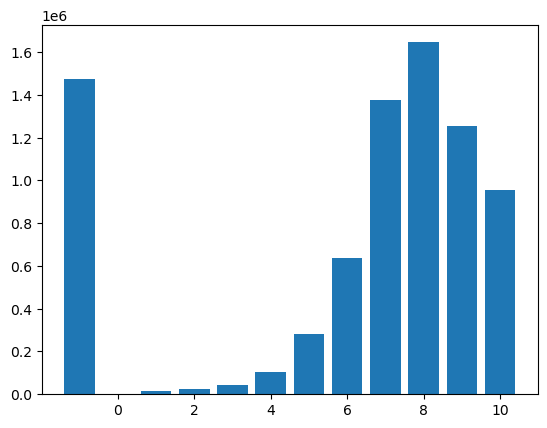

In [20]:
ratings_vc = ratings_cleaned["rating"].value_counts().sort_index()
rating_values, rating_counts = list(ratings_vc.index), list(ratings_vc.values)
plt.bar(rating_values, rating_counts)
plt.show()

Users tend to rate anime with fairly high ratings, the most comming rating is 8. Ratings above 7 make up the majority of ratings. A sizable portion of interations are unrated.

In [21]:
# count number of unrated interactions
# all_minus1 = ratings_cleaned[ratings_cleaned["rating"]==-1]
# len(all_minus1)

In [22]:
# users_no_rating = all_minus1["user_id"].unique()
# len(users_no_rating)

roughly half of our users have at least 1 unrated anime.

In [23]:
# users_who_never_rate = []
# for user in users_no_rating:
#     all_their_ratings = ratings_cleaned[ratings_cleaned["user_id"]==user]["rating"].unique()
#     if len(all_their_ratings) == 1:
#         users_who_never_rate.append(user)

# len(users_who_never_rate)

There is a population of users who have never rated but it is a small population out of the users who have at least one "watched but not rated" anime. I don't think it's worth executing anything special for them.

In [24]:
ratings_point5 = ratings_cleaned.copy(deep=True)
ratings_5 = ratings_cleaned.copy(deep=True)
ratings_7 = ratings_cleaned.copy(deep=True)

ratings_point5["rating"] = ratings_point5["rating"].replace(-1, 0.5)
ratings_5["rating"] = ratings_5["rating"].replace(-1, 5)
ratings_7["rating"] = ratings_7["rating"].replace(-1, 7)

### *Save to csv (if you have not already done so)

In [25]:
# Save these options to csv
# ratings_point5.to_csv("../data/05_model_input/ratings_point5.csv", index=False)
# ratings_5.to_csv("../data/05_model_input/ratings_5.csv", index=False)
# ratings_7.to_csv("../data/05_model_input/ratings_7.csv", index=False)

In [26]:
# Code to load the csvs back to dataframe
# ratings_point5 = pd.read_csv("../data/05_model_input/ratings_point5.csv")
# ratings_5 = pd.read_csv("../data/05_model_input/ratings_5.csv")
# ratings_7 = pd.read_csv("../data/05_model_input/ratings_7.csv")

### *Convert ratings data 

In [27]:
# convert data into list of tuples
# this version of the data did not change the -1 values
ratings_data = [tuple(row) for row in ratings_cleaned.itertuples(index=False)]
ratings_point5_data = [tuple(row) for row in ratings_point5.itertuples(index=False)]
ratings_5_data = [tuple(row) for row in ratings_5.itertuples(index=False)]
ratings_7_data = [tuple(row) for row in ratings_7.itertuples(index=False)]

In [28]:
# ratings_data

# *Model Baselines (Ratings data only)

## -------------------
## Damien and Ros!!!
## -------------------

only run the next cell in this section to define eval metrics

In [29]:
# mf10 = MF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.01, use_bias=False,
#         verbose=VERBOSE, seed=SEED, name=f"MF(K=10)")
# wmf10 = WMF(k=10, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
#           verbose=VERBOSE, seed=SEED, name=f"WMF(K=10)")
# mf50 = MF(k=50, max_iter=100, learning_rate=0.001, lambda_reg=0.01, use_bias=False,
#         verbose=VERBOSE, seed=SEED, name=f"MF(K=50)")
# wmf50 = WMF(k=50, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
#           verbose=VERBOSE, seed=SEED, name=f"WMF(K=50)")
# mf100 = MF(k=100, max_iter=100, learning_rate=0.001, lambda_reg=0.01, use_bias=False,
#         verbose=VERBOSE, seed=SEED, name=f"MF(K=100)")
# wmf100 = WMF(k=100, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
#           verbose=VERBOSE, seed=SEED, name=f"WMF(K=100)")



eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=20),
  cornac.metrics.Recall(k=20),
  cornac.metrics.FMeasure(k=20),
  cornac.metrics.NDCG(k=20),
  cornac.metrics.NCRR(k=20),
  cornac.metrics.Precision(k=50),
  cornac.metrics.Recall(k=50),
  cornac.metrics.FMeasure(k=50),
  cornac.metrics.NDCG(k=50),
  cornac.metrics.NCRR(k=50),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]

### Unrated = -1

In [30]:
# rs = RatioSplit(ratings_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

# cornac.Experiment(eval_method=rs, models=[
#         mf10, wmf10,
#         mf50, wmf50,
#         mf100, wmf100], metrics=eval_metrics).run()

### Unrated = 0.5

In [31]:
# rs = RatioSplit(ratings_point5_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

# cornac.Experiment(eval_method=rs, models=[
#         mf10, wmf10,
#         mf50, wmf50,
#         mf100, wmf100], metrics=eval_metrics).run()

### Unrated = 5

In [32]:
# rs = RatioSplit(ratings_5_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

# cornac.Experiment(eval_method=rs, models=[
#         mf10, wmf10,
#         mf50, wmf50, 
#         mf100, wmf100], metrics=eval_metrics).run()

### Unrated = 7

In [33]:
# rs = RatioSplit(ratings_7_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

# cornac.Experiment(eval_method=rs, models=[
#         mf10, wmf10,
#         mf50, wmf50,
#         mf100, wmf100], metrics=eval_metrics).run()

### Unrated = 7 appears to give the best predictions on ranking based metrics
### K=100 appears to give the best ranking based results

In [34]:
# dmrl100 = DMRL(batch_size=128, epochs=20, log_metrics=False, learning_rate=0.01, num_factors=2, 
#         decay_r=0.5, decay_c=0.01, num_neg=3, embedding_dim=100, name='dmrl(emb_dim=100)')

In [35]:
# rs = RatioSplit(ratings_7_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

# # cornac.Experiment(eval_method=rs, models=[
# #         ease100, dmrl100], metrics=eval_metrics).run()
# cornac.Experiment(eval_method=rs, models=[
#         dmrl100], metrics=eval_metrics).run()

### Image Modality (Damien)

In [36]:
# VBPR Experiments preprocessing
image_ids = list(content['anime_id'])
print(image_ids[:10])

width, height = 225, 320
black_image = Image.new('RGB', (width, height), (0, 0, 0))
black_image.save('../data/05_model_input/images/black_image.jpg', 'JPEG')

img_features_list = []
model = VGG16(weights='imagenet', include_top=False)

for i in tqdm(range(len(image_ids))):
    try:
        img_path = f"../data/05_model_input/images/{image_ids[i]}.jpg"
    except:
        img_path = '../data/05_model_input/images/black_image.jpg'

    img = image.load_img(img_path, target_size = (224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose=0)
    features_flat = features.flatten()
    img_features_list.append(features_flat)

print(f"# of tensors: {len(img_features_list)}")
print(f"Length of tensors: {len(img_features_list[0])}")

[32281, 5114, 28977, 9253, 9969, 32935, 11061, 820, 15335, 15417]


100%|██████████| 11094/11094 [11:19<00:00, 16.34it/s]

# of tensors: 11094
Length of tensors: 25088


In [38]:
# Dimensionality reduction: PCA
img_features_array = np.array(img_features_list)
img_features_tensor = torch.FloatTensor(img_features_array)

item_ids = list(content["anime_id_remapped"])
pca = PCA(100)
img_features_tensor_PCA = pca.fit_transform(img_features_tensor)

print(f"Original length of tensors: {len(img_features_list[0])}")
print(f"New length of tensors: {len(img_features_tensor_PCA[0])}")

item_image_modality_PCA = ImageModality(
    features=img_features_tensor_PCA, 
    ids=item_ids, 
    normalized=True
    )

Original length of tensors: 25088
New length of tensors: 100


In [39]:
# VBPR Experiments: PCA

K = 20

vbpr_PCA = VBPR(k=K, k2=K, n_epochs=50, batch_size=100, learning_rate=0.001,
            lambda_w=1, lambda_b=0.01, lambda_e=0.0, use_gpu=True, verbose=VERBOSE, seed=SEED)

rs = RatioSplit(ratings_7_data, test_size=0.2, item_image=item_image_modality_PCA, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[vbpr_PCA], metrics=eval_metrics).run()

# Model export
vbpr_PCA.save("../data/06_models")

c:\Users\user\.conda\envs\cs608_p2\Lib\site-packages\cornac\data\dataset.py:335: UserWarning: 5 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


Optimization finished!

TEST:
...
     |   RMSE |    AUC |  F1@20 |  F1@50 |    MAP |    MRR | NCRR@20 | NCRR@50 | NDCG@20 | NDCG@50 | Precision@20 | Precision@50 | Recall@20 | Recall@50 |  Train (s) | Test (s)
---- + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------- + ------------ + ------------ + --------- + --------- + ---------- + --------
VBPR | 7.0148 | 0.9476 | 0.0789 | 0.0873 | 0.0766 | 0.2918 |  0.1371 |  0.1397 |  0.1365 |  0.1591 |       0.0964 |       0.0744 |    0.1177 |    0.2164 | 26650.8577 | 222.9866



'../data/06_models\\VBPR\\2024-06-18_18-18-59-264311.pkl'

In [40]:
# Dimensionality reduction: TruncatedSVD
# img_features_array = np.array(img_features_list)
# img_features_tensor = torch.FloatTensor(img_features_array)

truncatedSVD = TruncatedSVD(100)
img_features_tensor_TSVD = truncatedSVD.fit_transform(img_features_tensor)

print(f"Original length of tensors: {len(img_features_list[0])}")
print(f"New length of tensors: {len(img_features_tensor_TSVD[0])}")

item_ids = list(content["anime_id_remapped"])

item_image_modality_TSVD = ImageModality(
    features=img_features_tensor_TSVD, 
    ids=item_ids, 
    normalized=True
    )

Original length of tensors: 25088
New length of tensors: 100


In [41]:
# VBPR Experiments: TSVD

K = 20

vbpr_TSVD = VBPR(k=K, k2=K, n_epochs=50, batch_size=100, learning_rate=0.001,
            lambda_w=1, lambda_b=0.01, lambda_e=0.0, use_gpu=True, verbose=VERBOSE, seed=SEED)

rs = RatioSplit(ratings_7_data, test_size=0.2, item_image=item_image_modality_TSVD, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[vbpr_TSVD], metrics=eval_metrics).run()

# Model export
vbpr_TSVD.save("../data/06_models")

c:\Users\user\.conda\envs\cs608_p2\Lib\site-packages\cornac\data\dataset.py:335: UserWarning: 5 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


Optimization finished!

TEST:
...
     |   RMSE |    AUC |  F1@20 |  F1@50 |    MAP |    MRR | NCRR@20 | NCRR@50 | NDCG@20 | NDCG@50 | Precision@20 | Precision@50 | Recall@20 | Recall@50 |  Train (s) | Test (s)
---- + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------- + ------------ + ------------ + --------- + --------- + ---------- + --------
VBPR | 7.0251 | 0.9475 | 0.0789 | 0.0884 | 0.0742 | 0.2807 |  0.1322 |  0.1350 |  0.1337 |  0.1575 |       0.0968 |       0.0752 |    0.1175 |    0.2199 | 26398.5541 | 214.6498



'../data/06_models\\VBPR\\2024-06-19_01-43-22-153770.pkl'